<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/Universal_PyTorch2_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Utilities

In [3]:

import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday, persistence_probabilistic
# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


  Using cached solarforecastarbiter-1.0.13-py3-none-any.whl (8.2 MB)
  Using cached netCDF4-1.6.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.4 MB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have 

In [5]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "lat":21.446911,
        "lon":-158.188736,
        "fresh_data_time":'12',
    },
    'or': {
        "lat":45.114559,
        "lon":-123.204903,
        "fresh_data_time":'12',
    },
    'tx': {
        "lat":29.424122,
        "lon":-98.493629,
        "fresh_data_time":'06',
    },
    'ga': {
        "lat":31.044241,
        "lon":-84.879128,
        "fresh_data_time":'06',
    },

}
tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df




# def make_reference_forecasts(start_date, end_date, location)

#     location_meta_data = {
#         'tx': ['San Antonio, TX Substation',states['tx']['lat'],]
#     }


#     name = 'San Antonio, TX Substation'
#     latitude = lat
#     longitude = lon
#     elevation = 4.0
#     timezone = local_time_zone
#     site_id = 'c639b1f3-eb8f-11ed-802e-aec5a60999dc'
#     site = Site(name = name, latitude = latitude, longitude = longitude, elevation = elevation,
#                 timezone = timezone, site_id = site_id)

#     variable = 'net_load'
#     interval_value_type = 'interval_mean'
#     interval_length = pd.Timedelta(value = 1, unit = 'hour')
#     interval_label = 'ending'
#     site = site
#     uncertainty = 0
#     obs = Observation(name = name, variable = variable,
#                       interval_value_type = interval_value_type,
#                       interval_length = interval_length,
#                       interval_label = interval_label,
#                       site = site, uncertainty = uncertainty)

#     observation  = obs
#     data_start  = start_time
#     data_end = end_time
#     forecast_start = target_start_time
#     forecast_end  = target_end_time
#     interval_length = interval_length
#     interval_label = 'ending'
#     load_data = load_data
#     axis = 'x'
#     constant_values = np.array([x/10 for x in range(1,10)])


#     baseline = persistence_probabilistic(observation = obs,
#                                         data_start = data_start,
#                                         data_end = data_end,
#                                         forecast_start = forecast_start,
#                                         forecast_end = forecast_end,
#                                         interval_length = interval_length,
#                                         interval_label = interval_label,
#                                         load_data = load_data,
#                                         axis = 'y',
#                                         constant_values = constant_values)


# Feature engineering


In [6]:
state_location = 'ga'
training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/georgia_historical.csv')
total_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/georgia_2022-01-01-2023-06-28_total.csv')
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/georgia_2023-06-30_test.csv')

In [7]:
training_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
test_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)

training_data.drop(columns = 'quality_flag', inplace = True)
test_data.drop(columns = 'quality_flag', inplace = True)

In [8]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.000000,20.9,93,19.7,23.1,0.0,92,5,42,92,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
1,2023-06-01 02:00:00,0.186776,20.8,93,19.6,22.8,0.0,99,1,22,99,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
2,2023-06-01 03:00:00,0.172414,20.6,92,19.2,22.7,0.0,74,74,25,16,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
3,2023-06-01 04:00:00,0.169535,20.8,91,19.2,22.9,0.0,100,2,100,49,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
4,2023-06-01 05:00:00,0.163793,20.8,89,18.9,22.5,0.0,56,0,44,56,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,33.5,53,22.6,37.9,0.0,16,0,0,16,379.0,299.0,80.0,740.9,2023-07-03T20:48,2023-07-03T06:38
787,2023-07-03 20:00:00,NaN,31.8,61,23.3,36.9,0.0,50,0,0,49,182.0,134.0,48.0,612.4,2023-07-03T20:48,2023-07-03T06:38
788,2023-07-03 21:00:00,NaN,29.6,63,21.8,33.9,0.0,10,0,0,10,25.0,14.0,11.0,230.8,2023-07-03T20:48,2023-07-03T06:38
789,2023-07-03 22:00:00,NaN,26.8,77,22.4,30.9,0.7,11,6,0,5,0.0,0.0,0.0,0.0,2023-07-03T20:48,2023-07-03T06:38


In [9]:
training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

In [10]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.000000,20.9,93,19.7,23.1,0.0,92,5,42,92,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
1,2023-06-01 02:00:00,0.186776,20.8,93,19.6,22.8,0.0,99,1,22,99,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
2,2023-06-01 03:00:00,0.172414,20.6,92,19.2,22.7,0.0,74,74,25,16,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
3,2023-06-01 04:00:00,0.169535,20.8,91,19.2,22.9,0.0,100,2,100,49,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
4,2023-06-01 05:00:00,0.163793,20.8,89,18.9,22.5,0.0,56,0,44,56,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,33.5,53,22.6,37.9,0.0,16,0,0,16,379.0,299.0,80.0,740.9,2023-07-03T20:48,2023-07-03T06:38
787,2023-07-03 20:00:00,NaN,31.8,61,23.3,36.9,0.0,50,0,0,49,182.0,134.0,48.0,612.4,2023-07-03T20:48,2023-07-03T06:38
788,2023-07-03 21:00:00,NaN,29.6,63,21.8,33.9,0.0,10,0,0,10,25.0,14.0,11.0,230.8,2023-07-03T20:48,2023-07-03T06:38
789,2023-07-03 22:00:00,NaN,26.8,77,22.4,30.9,0.7,11,6,0,5,0.0,0.0,0.0,0.0,2023-07-03T20:48,2023-07-03T06:38


In [11]:
training_data['hours'] = (training_data.time.dt.hour - 12) / 24
test_data['hours'] = (test_data.time.dt.hour - 12) / 24

In [12]:

test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.000000,20.9,93,19.7,23.1,0.0,92,5,42,92,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35,-0.458333
1,2023-06-01 02:00:00,0.186776,20.8,93,19.6,22.8,0.0,99,1,22,99,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35,-0.416667
2,2023-06-01 03:00:00,0.172414,20.6,92,19.2,22.7,0.0,74,74,25,16,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35,-0.375000
3,2023-06-01 04:00:00,0.169535,20.8,91,19.2,22.9,0.0,100,2,100,49,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35,-0.333333
4,2023-06-01 05:00:00,0.163793,20.8,89,18.9,22.5,0.0,56,0,44,56,0.0,0.0,0.0,0.0,2023-06-01T20:39,2023-06-01T06:35,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,33.5,53,22.6,37.9,0.0,16,0,0,16,379.0,299.0,80.0,740.9,2023-07-03T20:48,2023-07-03T06:38,0.291667
787,2023-07-03 20:00:00,NaN,31.8,61,23.3,36.9,0.0,50,0,0,49,182.0,134.0,48.0,612.4,2023-07-03T20:48,2023-07-03T06:38,0.333333
788,2023-07-03 21:00:00,NaN,29.6,63,21.8,33.9,0.0,10,0,0,10,25.0,14.0,11.0,230.8,2023-07-03T20:48,2023-07-03T06:38,0.375000
789,2023-07-03 22:00:00,NaN,26.8,77,22.4,30.9,0.7,11,6,0,5,0.0,0.0,0.0,0.0,2023-07-03T20:48,2023-07-03T06:38,0.416667


In [13]:
test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = ((test_data.sunrise.dt.hour - 12) / 24) + ((test_data.sunrise.dt.minute - 30) / 60)
test_data.sunset = ((test_data.sunset.dt.hour - 12) / 24) + ((test_data.sunset.dt.minute - 30) / 60)

In [14]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.000000,20.9,93,19.7,23.1,0.0,92,5,42,92,0.0,0.0,0.0,0.0,0.483333,-0.166667,-0.458333
1,2023-06-01 02:00:00,0.186776,20.8,93,19.6,22.8,0.0,99,1,22,99,0.0,0.0,0.0,0.0,0.483333,-0.166667,-0.416667
2,2023-06-01 03:00:00,0.172414,20.6,92,19.2,22.7,0.0,74,74,25,16,0.0,0.0,0.0,0.0,0.483333,-0.166667,-0.375000
3,2023-06-01 04:00:00,0.169535,20.8,91,19.2,22.9,0.0,100,2,100,49,0.0,0.0,0.0,0.0,0.483333,-0.166667,-0.333333
4,2023-06-01 05:00:00,0.163793,20.8,89,18.9,22.5,0.0,56,0,44,56,0.0,0.0,0.0,0.0,0.483333,-0.166667,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,33.5,53,22.6,37.9,0.0,16,0,0,16,379.0,299.0,80.0,740.9,0.633333,-0.116667,0.291667
787,2023-07-03 20:00:00,NaN,31.8,61,23.3,36.9,0.0,50,0,0,49,182.0,134.0,48.0,612.4,0.633333,-0.116667,0.333333
788,2023-07-03 21:00:00,NaN,29.6,63,21.8,33.9,0.0,10,0,0,10,25.0,14.0,11.0,230.8,0.633333,-0.116667,0.375000
789,2023-07-03 22:00:00,NaN,26.8,77,22.4,30.9,0.7,11,6,0,5,0.0,0.0,0.0,0.0,0.633333,-0.116667,0.416667


In [15]:
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = ((training_data.sunrise.dt.hour - 12) / 24) + ((training_data.sunrise.dt.minute - 30) / 60)
training_data.sunset = ((training_data.sunset.dt.hour - 12) / 24) + ((training_data.sunset.dt.minute - 30) / 60)

In [77]:
training_data['month'] = training_data.time.dt.month
test_data['month'] = test_data.time.dt.month

In [78]:
# test_data[test_data.value.isna()]

In [79]:
lookback_start = 5
lookback_end = 9
lookback_dim = lookback_end - lookback_start + 1

for i in range(lookback_start, lookback_end + 1):
  training_data['prev_{}'.format(i)] = training_data.shift(i * 24).value
  test_data['prev_{}'.format(i)] = test_data.shift(i * 24).value



In [80]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8,prev_9
0,2023-06-01 01:00:00,0.000000,20.9,93,19.7,23.1,0.0,92,5,42,...,0.0,0.483333,-0.166667,-0.458333,6,NaN,NaN,NaN,NaN,NaN
1,2023-06-01 02:00:00,0.186776,20.8,93,19.6,22.8,0.0,99,1,22,...,0.0,0.483333,-0.166667,-0.416667,6,NaN,NaN,NaN,NaN,NaN
2,2023-06-01 03:00:00,0.172414,20.6,92,19.2,22.7,0.0,74,74,25,...,0.0,0.483333,-0.166667,-0.375000,6,NaN,NaN,NaN,NaN,NaN
3,2023-06-01 04:00:00,0.169535,20.8,91,19.2,22.9,0.0,100,2,100,...,0.0,0.483333,-0.166667,-0.333333,6,NaN,NaN,NaN,NaN,NaN
4,2023-06-01 05:00:00,0.163793,20.8,89,18.9,22.5,0.0,56,0,44,...,0.0,0.483333,-0.166667,-0.291667,6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,33.5,53,22.6,37.9,0.0,16,0,0,...,740.9,0.633333,-0.116667,0.291667,7,NaN,0.172414,0.112069,0.109190,0.109190
787,2023-07-03 20:00:00,NaN,31.8,61,23.3,36.9,0.0,50,0,0,...,612.4,0.633333,-0.116667,0.333333,7,NaN,0.232759,0.206897,0.227017,0.186776
788,2023-07-03 21:00:00,NaN,29.6,63,21.8,33.9,0.0,10,0,0,...,230.8,0.633333,-0.116667,0.375000,7,NaN,0.318966,0.301724,0.304603,0.275862
789,2023-07-03 22:00:00,NaN,26.8,77,22.4,30.9,0.7,11,6,0,...,0.0,0.633333,-0.116667,0.416667,7,NaN,0.336207,0.310345,0.318966,0.293103


In [81]:
training_data.columns

Index(['time', 'value', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance',
       'sunset', 'sunrise', 'hours', 'month', 'prev_5', 'prev_6', 'prev_7',
       'prev_8', 'prev_9'],
      dtype='object')

In [82]:
training_data = training_data[(training_data.prev_8.isna() == False)].reset_index().drop(columns = 'index')

In [83]:
training_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8,prev_9
0,2022-01-09 01:00:00,0.189655,12.1,90,10.6,10.1,0.0,43,0,51,...,0.0,0.683333,-0.050000,-0.458333,1,0.362069,0.137931,0.155172,0.172414,NaN
1,2022-01-09 02:00:00,0.189655,12.2,91,10.9,10.3,0.0,67,0,95,...,0.0,0.683333,-0.050000,-0.416667,1,0.362069,0.120690,0.155172,0.155172,NaN
2,2022-01-09 03:00:00,0.189655,12.7,93,11.5,10.9,0.0,63,1,90,...,0.0,0.683333,-0.050000,-0.375000,1,0.362069,0.120690,0.155172,0.155172,NaN
3,2022-01-09 04:00:00,0.189655,13.0,93,12.0,11.5,0.0,38,4,51,...,0.0,0.683333,-0.050000,-0.333333,1,0.344828,0.120690,0.137931,0.137931,NaN
4,2022-01-09 05:00:00,0.189655,13.4,94,12.4,12.0,0.0,23,12,15,...,0.0,0.683333,-0.050000,-0.291667,1,0.379310,0.137931,0.137931,0.137931,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12161,2023-05-30 20:00:00,0.215517,25.2,61,17.1,27.2,0.0,74,0,79,...,146.3,0.466667,-0.166667,0.333333,5,0.114948,0.054603,0.123569,0.201155,0.212638
12162,2023-05-30 21:00:00,0.278741,24.4,63,16.8,26.1,0.0,53,0,39,...,39.0,0.466667,-0.166667,0.375000,5,0.204017,0.158052,0.163793,0.169535,0.272983
12163,2023-05-30 22:00:00,0.298845,23.7,63,16.3,25.0,0.0,39,0,15,...,0.0,0.466667,-0.166667,0.416667,5,0.224138,0.212638,0.181035,0.175293,0.301724
12164,2023-05-30 23:00:00,0.287362,22.5,69,16.5,23.7,0.0,34,0,7,...,0.0,0.466667,-0.166667,0.458333,5,0.224138,0.218397,0.192535,0.189655,0.293103


In [84]:
new_df = training_data[(training_data.value.isna() == False) &
                   (training_data['prev_{}'.format(lookback_end)].isna() == False)].drop(columns = 'time')
# new_df = training_data[((training_data['time'] <= '2022-10-01 00:00:00') & (training_data['time'] >= '2022-05-01 00:00:00'))].drop(columns = 'time')


In [85]:
new_df

,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,...,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8,prev_9
24,0.172414,18.1,99,18.0,19.6,0.6,100,100,4,100,...,0.0,0.683333,-0.050000,-0.458333,1,0.293103,0.362069,0.137931,0.155172,0.172414
25,0.155172,18.0,100,17.9,19.5,0.2,100,100,0,100,...,0.0,0.683333,-0.050000,-0.416667,1,0.275862,0.362069,0.120690,0.155172,0.155172
26,0.155172,17.9,100,17.8,19.1,0.2,100,100,26,88,...,0.0,0.683333,-0.050000,-0.375000,1,0.275862,0.362069,0.120690,0.155172,0.155172
27,0.137931,17.9,99,17.8,19.1,0.0,100,100,22,80,...,0.0,0.683333,-0.050000,-0.333333,1,0.258621,0.344828,0.120690,0.137931,0.137931
28,0.155172,17.9,99,17.8,19.2,0.0,100,100,88,91,...,0.0,0.683333,-0.050000,-0.291667,1,0.241379,0.379310,0.137931,0.137931,0.137931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12161,0.215517,25.2,61,17.1,27.2,0.0,74,0,79,88,...,146.3,0.466667,-0.166667,0.333333,5,0.114948,0.054603,0.123569,0.201155,0.212638
12162,0.278741,24.4,63,16.8,26.1,0.0,53,0,39,100,...,39.0,0.466667,-0.166667,0.375000,5,0.204017,0.158052,0.163793,0.169535,0.272983
12163,0.298845,23.7,63,16.3,25.0,0.0,39,0,15,99,...,0.0,0.466667,-0.166667,0.416667,5,0.224138,0.212638,0.181035,0.175293,0.301724
12164,0.287362,22.5,69,16.5,23.7,0.0,34,0,7,100,...,0.0,0.466667,-0.166667,0.458333,5,0.224138,0.218397,0.192535,0.189655,0.293103


In [86]:


val_df = test_data[(test_data.value.isna() == False) &
                   (test_data['prev_{}'.format(lookback_end)].isna() == False)].drop(columns = 'time')
test_df_new = test_data[test_data.value.isna() == True][-24-23:-23].reset_index().drop(columns = ['index','time'])

In [87]:
test_data[(test_data.value.isna() == False) & (test_data.prev_8.isna() == False)]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,direct_normal_irradiance,sunset,sunrise,hours,month,prev_5,prev_6,prev_7,prev_8,prev_9
192,2023-06-09 01:00:00,0.290224,25.1,70,19.3,27.8,0.0,0,0,0,...,0.0,0.550000,-0.200000,-0.458333,6,0.000000,0.000000,0.000000,0.000000,NaN
193,2023-06-09 02:00:00,0.255741,23.7,75,19.0,26.5,0.0,0,0,0,...,0.0,0.550000,-0.200000,-0.416667,6,0.198276,0.192535,0.169535,0.186776,NaN
194,2023-06-09 03:00:00,0.238500,23.2,79,19.4,26.0,0.0,0,0,0,...,0.0,0.550000,-0.200000,-0.375000,6,0.183914,0.178155,0.155172,0.172414,NaN
195,2023-06-09 04:00:00,0.221259,21.9,89,20.0,25.3,0.0,3,3,0,...,0.0,0.550000,-0.200000,-0.333333,6,0.172414,0.166672,0.152293,0.169535,NaN
196,2023-06-09 05:00:00,0.221259,22.1,94,21.0,26.2,0.0,10,10,0,...,0.0,0.550000,-0.200000,-0.291667,6,0.163793,0.158052,0.160914,0.163793,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2023-06-27 20:00:00,0.232759,31.5,67,24.6,36.8,0.0,0,0,0,...,326.9,0.633333,-0.150000,0.333333,6,0.166672,0.186776,0.186776,0.146552,0.163793
644,2023-06-27 21:00:00,0.318966,29.5,77,25.0,35.1,0.0,0,0,0,...,62.8,0.633333,-0.150000,0.375000,6,0.229879,0.175293,0.272983,0.183914,0.160914
645,2023-06-27 22:00:00,0.336207,28.5,82,25.1,34.5,0.0,0,0,0,...,0.0,0.633333,-0.150000,0.416667,6,0.229879,0.183914,0.281603,0.221259,0.201155
646,2023-06-27 23:00:00,0.330466,27.7,85,24.9,33.8,0.0,0,0,0,...,0.0,0.633333,-0.150000,0.458333,6,0.204017,0.198276,0.281603,0.227017,0.206897


In [88]:
val_df=val_df[new_df.columns]
test_df_new=test_df_new[new_df.columns]

# Train Val Split

In [89]:
X_train = new_df[[col for col in new_df.columns if col != 'value']]
y_train = new_df.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


In [90]:
X_val = val_df[[col for col in val_df.columns if col != 'value']]
y_val = val_df.value
X_val = torch.from_numpy(X_val.values).to(torch.float64)
y_val = torch.from_numpy(y_val.values).to(torch.float64)

# Defining models

In [91]:
class TrendsModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(TrendsModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
    # self.fc2 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.relu = nn.ReLU().to(torch.float64)
    # self.softplus = nn.Softplus().to(torch.float64)
    self.softmax = nn.Softmax().to(torch.float64)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    # x = self.relu(x)
    # x = self.fc3(x)
    # x = self.relu(x)
    # x = self.fc4(x)
    # x = self.relu(x)
    # x = self.fc5(x)
    # x = self.relu(x)
    # x = self.fc6(x)
    # x = self.relu(x)
    # x = self.fc7(x)
    return x

class FeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(FeaturesModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.relu = nn.ReLU().to(torch.float64)
        # self.softplus = nn.Softplus().to(torch.float64)
        self.softmax = nn.Softmax().to(torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        # x = self.relu(x)
        # x = self.fc7(x)
        return x

class Trend_Feature_model(nn.Module):
  def __init__(self, feature_dim, feature_hidden, lookback_dim, hidden_dim, output_dim, trend_weight = 0.4):
    super(Trend_Feature_model, self).__init__()
    self.trends_model = TrendsModel(lookback_dim, hidden_dim, output_dim)
    self.features_model = FeaturesModel(feature_dim, feature_hidden, output_dim)
    self.combining_layer = nn.Linear(feature_hidden + hidden_dim, hidden_dim).to(torch.float64)
    self.output_layer = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.trend_weight = trend_weight
    self.relu = nn.ReLU().to(torch.float64)
    self.lookback_dim = lookback_dim
    self.hidden_dim = hidden_dim
  def forward(self, x):
    x_features = x[:,:-1 * self.lookback_dim]
    x_lookback = x[:,-1 * self.lookback_dim:]
    std_hour = x[:,-self.lookback_dim:].std(dim = 1).view(-1,1)
    feature_output = self.features_model(x_features)
    trends_output = self.trends_model(x_lookback)
    # x = (feature_output * (1 - self.trend_weight)) + (trends_output * self.trend_weight)
    x = torch.concat([feature_output,trends_output], axis = 1).to(torch.float64)
    # print(x.shape, self.hidden_dim)
    x = self.relu(x)
    x = self.combining_layer(x)
    x = self.relu(x)
    x = self.output_layer(x)

    vals = []
    for i in range(0, 11):
      q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

      pred2 = x + (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

      vals.append(pred2)

    x = torch.concat(vals, dim = 1)#.detach().numpy()

    return x



# Loss Functions

In [92]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()


def negLL(y_pred, y_true):
    mu = y_pred[:,6]
    prob_0 = y_pred[:,0]
    prob_100 = y_pred[:,-1]
    # print("y_pred.shape",y_pred.shape,"y_true.shape",y_true.shape)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((mu - y_true)/ 2) ** 2) #- torch.log(denom)
    loss += 0.1 * (((prob_0 - y_true)/ 2) ** 2)
    loss += 0.1 * (((prob_100 - y_true)/ 2) ** 2)
    return loss.mean()

def negLL2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((y_pred - obs)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def mae(y_pred, y_true):
    mu = y_pred[:,0]
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((mu - y_true))) #- torch.log(denom)
    return loss.mean()

def mae2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((y_pred - obs)/ 2)) #- torch.log(denom)
    return loss.mean()

#Dataloader

In [93]:

class CDataset(Dataset):
    def __init__(self, X, y):
        self.X = X#.values
        self.y = y#.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# Training Loop

In [94]:
# from torch._C import float64
# Define the custom data loaders
batch_size = 64
train_dataset = CDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
feature_dim = X_train.shape[1] - lookback_dim#22  # Specify the input feature dimensions
feature_hidden = 16
lookback_dim = lookback_dim
lookback_hidden = lookback_dim - 2

model = Trend_Feature_model(feature_dim = feature_dim, feature_hidden = int(feature_dim * 0.8),
                            lookback_dim=lookback_dim,
                            hidden_dim = lookback_hidden,
                            output_dim = 1,
                            trend_weight=0.9)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

            outputs = model(batch_X)
            # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
            # loss = negLL(outputs, batch_y)
            # loss = mae(outputs, batch_y)
            loss = crps_loss(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
        loss = crps_loss(outputs, batch_y)
        # loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/i)
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch [1/150], Train Loss: 0.07659132569570676, Val Loss: 0.19886861759099733
Epoch [2/150], Train Loss: 0.06249749630298141, Val Loss: 0.06803341496864089
Epoch [3/150], Train Loss: 0.06022906798804593, Val Loss: 0.05255812954612841
Epoch [4/150], Train Loss: 0.06045544747642428, Val Loss: 0.05130054175593762
Epoch [5/150], Train Loss: 0.07084385989568133, Val Loss: 0.0515218745762953
Epoch [6/150], Train Loss: 0.06901267448358482, Val Loss: 0.051714988396468986
Epoch [7/150], Train Loss: 0.057312509308562194, Val Loss: 0.05044570026754291
Epoch [8/150], Train Loss: 0.062105701738897956, Val Loss: 0.05081350390399431
Epoch [9/150], Train Loss: 0.05563199082872949, Val Loss: 0.051253525561554714
Epoch [10/150], Train Loss: 0.07050595083835623, Val Loss: 0.050444209009794384
Epoch [11/150], Train Loss: 0.05096592638006892, Val Loss: 0.051319982257783225
Epoch [12/150], Train Loss: 0.07487841279344697, Val Loss: 0.05084065871920385
Epoch [13/150], Train Loss: 0.06722847109995775, Val Los

In [95]:
# test_data

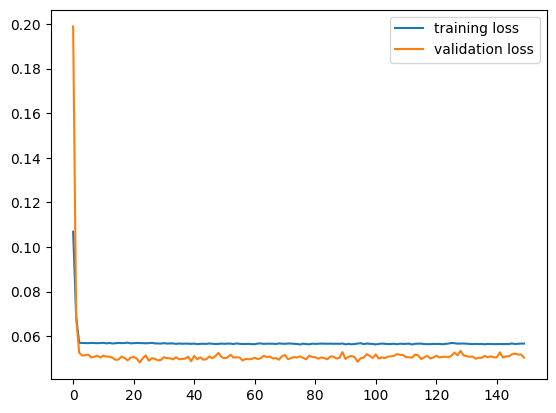

In [102]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

# Inspection Space

In [103]:
weather_cols = ['dewpoint_2m','relativehumidity_2m','temperature_2m',
                'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
                'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
                'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']
weather_dictionary = {col:[] for col in weather_cols}

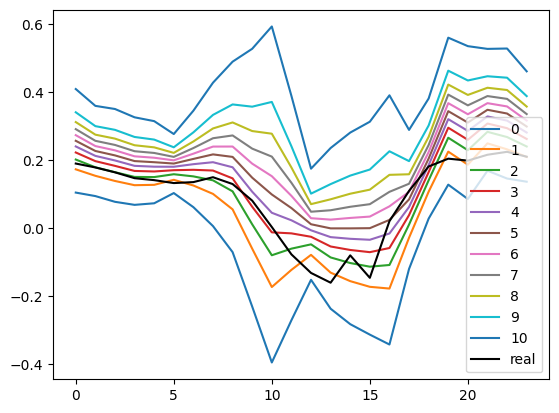

0.05904321134783131 -0.5062849354275569


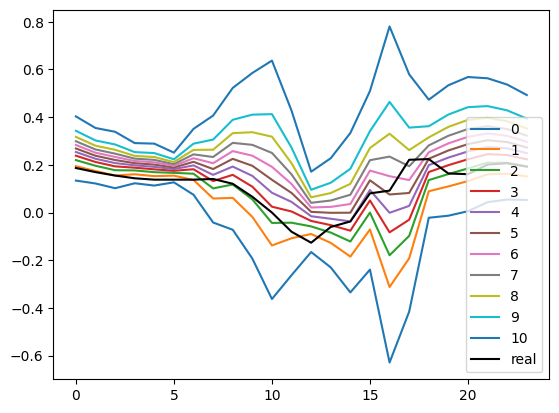

0.05960668319060275 -0.23671462214064798


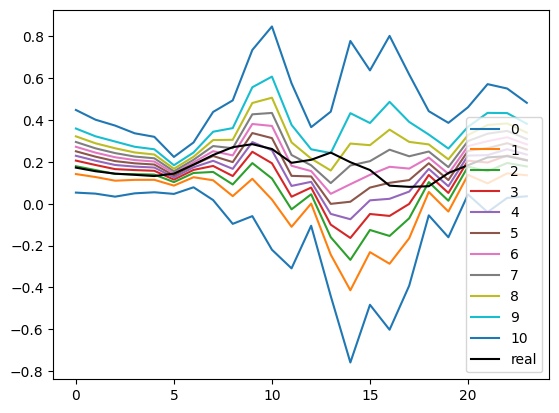

0.05619434247168351 0.006894331132014209


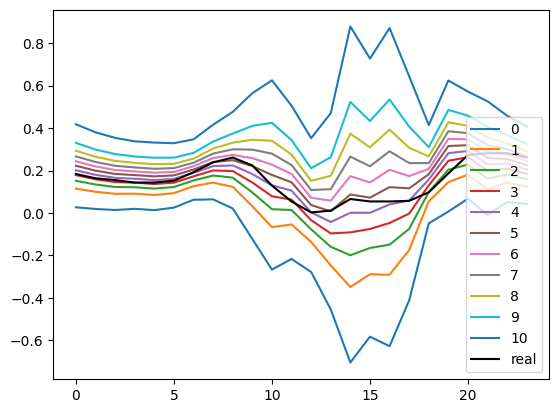

0.041351509117459384 -0.6840050148956085


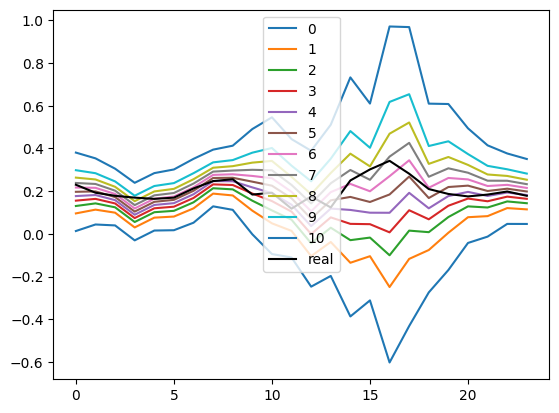

0.036932024246795946 0.4127849359513043


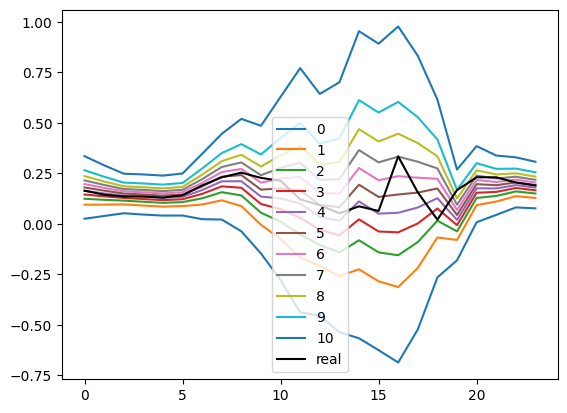

0.043085992401981764 -0.06584262262778995


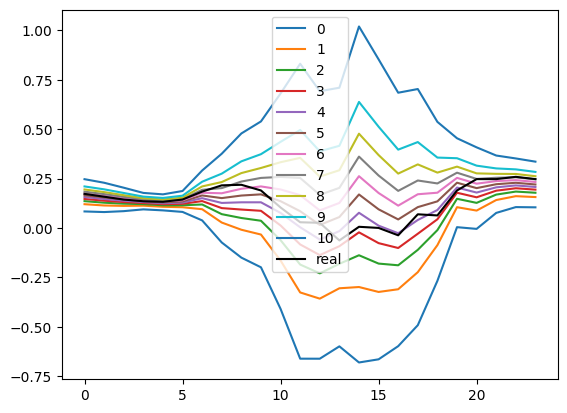

0.041005334606198096 -0.6169141719460305


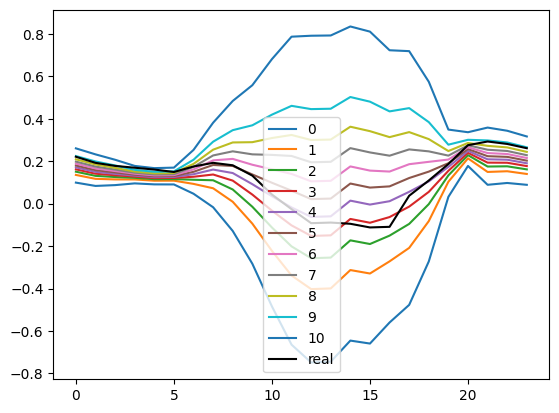

0.0505511140674722 -0.33466578199857144


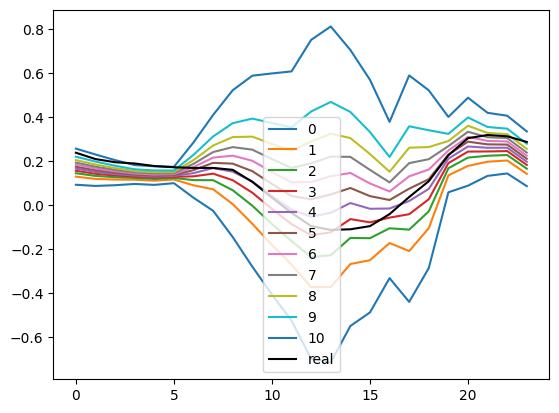

0.048364782957924714 -0.10343268274569817


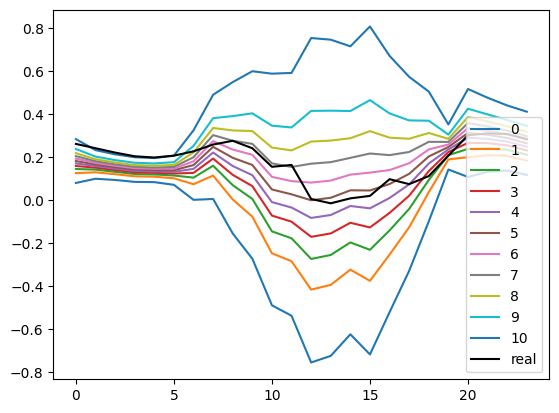

0.05055783125470716 -0.48266530770431926


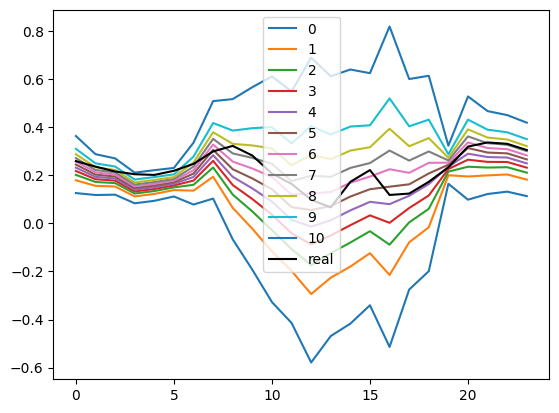

0.040363550314407415 0.24293071519409037


In [104]:
daily_crps = []
daily_crpss = []
for day in range(18, 29):

  start_date = '2023-06-{:02d}'.format(day - 1)
  end_date = '2023-06-{:02d}'.format(day)
  test_df = test_data[(test_data.time >= start_date + ' 01:00:00')
                    & (test_data.time <= end_date + ' 00:00:00')].drop(columns = 'time')

  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  hourly_deviations = []
  meanies = []
  std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


  vals = []
  for i in range(0, 11):
    # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()

  for col in weather_cols:
    weather_data = test_df[col].values
    weather_dictionary[col].append(test_df[col].std())


  pred = preds.detach().numpy()#torch.concat(vals, dim = 1).detach().numpy()

  # submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
  # submission['timestamp'] = pd.date_range(start = '2023-06-{0:2d} 01:00:00'.format(day - 1),
  #                                         end =  '2023-06-{0:2d} 00:00:00'.format(day),
  #                                         freq='H',
  #                                         tz = states['ga']['local_time_zone']
  #                                         )

  # submission[['p' + str(i*10) for i in range(11)]] = pred



  obs = y_test.detach().numpy()
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
  crps, crpss, _ = crps_and_crpss_scores(obs, pred, start_date, end_date, state_location)
  print(crps, crpss)
  daily_crps.append(crps)
  daily_crpss.append(crpss)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

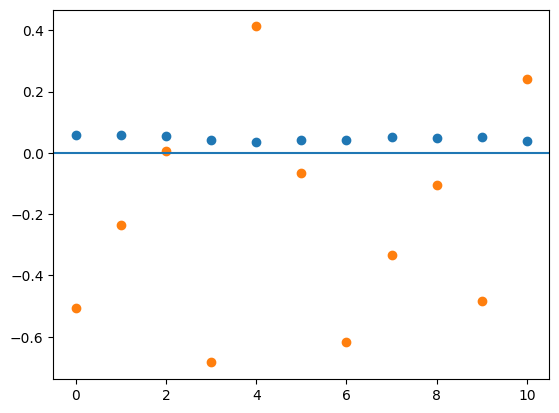

In [99]:
plt.scatter(range(len(daily_crps)), daily_crps)
plt.scatter(range(len(daily_crpss)), daily_crpss)
plt.axhline(0)
plt.show()

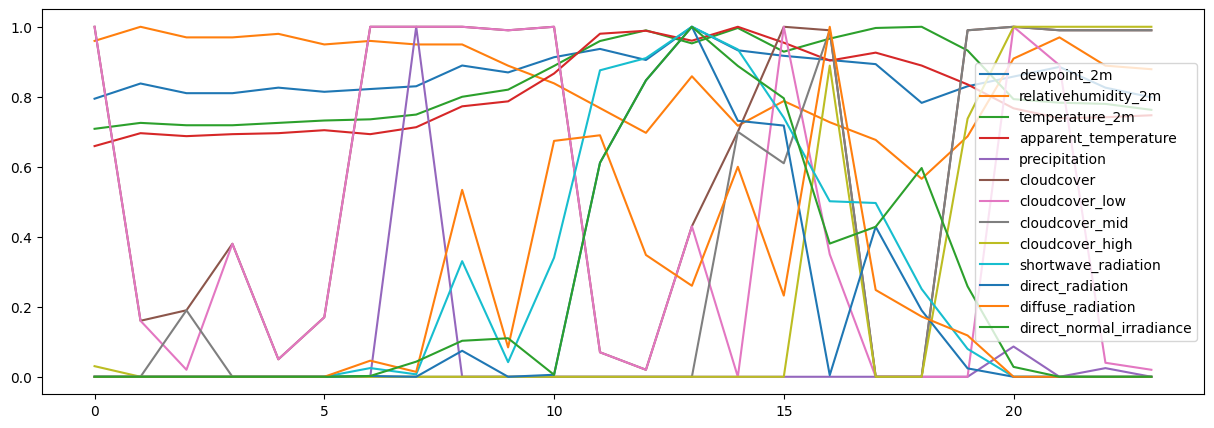

In [100]:
day = 23
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  weather_dictionary[col].append(test_df[col].std())
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

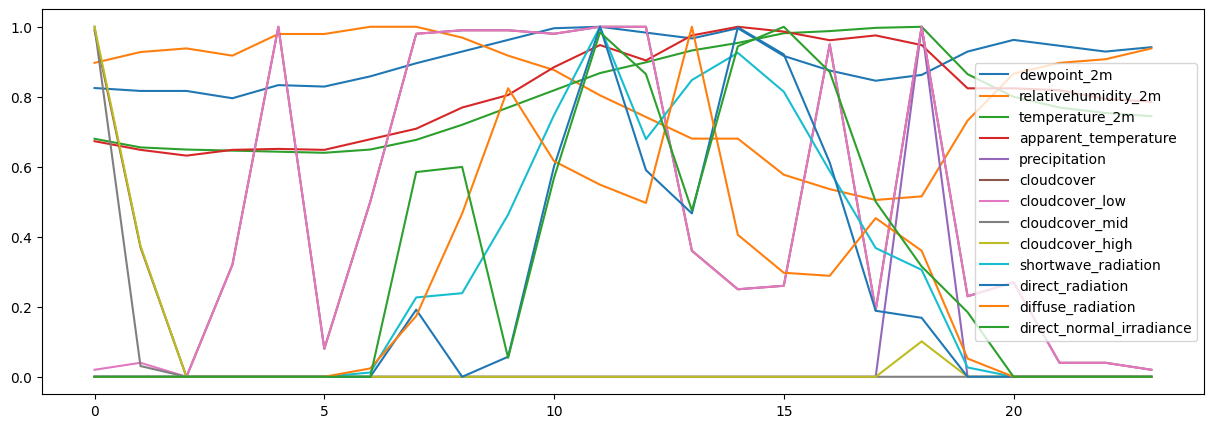

In [101]:
day = 24
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

In [ ]:
# current_day = -1
# biases = []
# predictions = []
# observations = []
# for i in range(lookback_start, lookback_end + 1):
#   test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
#   X_test = test_df[[col for col in test_df.columns if col != 'value']]
#   y_test = test_df.value
#   X_test = torch.from_numpy(X_test.values).to(torch.float64)
#   y_test = torch.from_numpy(y_test.values).to(torch.float64)

#   preds = model(X_test)

#   predictions.append(preds)
#   observations.append(y_test)

# mean_pred = torch.zeros((24,1))
# mean_obs = torch.zeros((24,1))

# for i in range(lookback_dim):
#   mean_pred += predictions[i]
#   mean_obs += observations[i].view(24,1)

# mean_obs /= lookback_dim
# mean_pred /= lookback_dim

# test_df = test_data[-23-24:-23].drop(columns = 'time')
# X_test = test_df[[col for col in test_df.columns if col != 'value']]
# y_test = test_df.value
# X_test = torch.from_numpy(X_test.values).to(torch.float64)
# y_test = torch.from_numpy(y_test.values).to(torch.float64)

# preds = model(X_test)

# hourly_deviations = []
# meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


# vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias


#   pred2 = preds + std_hour * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
#   plt.plot(pred2.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

# pred = torch.concat(vals, dim = 1).detach().numpy()


# BIAS CORRECTION AND SUBMISSION

In [ ]:
test_df = test_data[-23-24-24:-23-24]#.drop(columns = 'time')

In [ ]:
current_day = -1
biases = []
predictions = []
observations = []
for i in range(lookback_start, lookback_end + 1):
  test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  predictions.append(preds)
  observations.append(y_test)

mean_pred = torch.zeros((24,1))
mean_obs = torch.zeros((24,1))

for i in range(lookback_dim):
  mean_pred += predictions[i]
  mean_obs += observations[i].view(24,1)

mean_obs /= lookback_dim
mean_pred /= lookback_dim

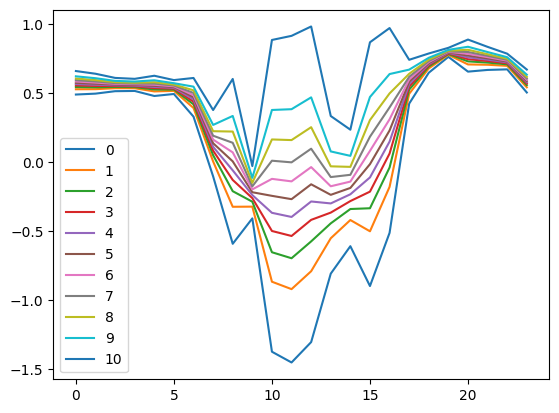

In [ ]:
# j = 1
# trial_x, trial_y = X_test[-24 * (j): -24 * (j-1)], y_test[-24 * (j): -24 * (j-1)]

test_df = test_data[-23-24-24:-23-24].drop(columns = 'time')
X_test = test_df[[col for col in test_df.columns if col != 'value']]
y_test = test_df.value
X_test = torch.from_numpy(X_test.values).to(torch.float64)
y_test = torch.from_numpy(y_test.values).to(torch.float64)

preds = model(X_test)#torch.from_numpy(X).to(torch.float64))#.shape

hourly_deviations = []
meanies = []
std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)#new_df[new_df['hour'] == float(i)]['value'].std()


vals = []
for i in range(0, 11):
  q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
  bias = mean_pred - mean_obs
  corrected_mean = preds - bias#(preds - mean)


  pred2 = preds +  (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

  vals.append(pred2)
  plt.plot(pred2.detach().numpy(), label = str(i))

plt.legend()
plt.show()

pred = torch.concat(vals, dim = 1).detach().numpy()

# Submission Block

In [ ]:
from datetime import datetime


In [ ]:
submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
submission['timestamp'] = pd.date_range(start = '2023-07-01 01:00:00',
                                         end =  '2023-07-02 00:00:00',
                                         freq='H',
                                         tz = states[state_location]['local_time_zone']
                                         )
submission[['p' + str(i*10) for i in range(11)]] = pred

submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/hi_pytorch2_submission_{}.csv".format(datetime.now()))

upload_function(submission.set_index('timestamp'),state_location)